In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import time
import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.rnn_biogas import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'biogas'), ('in_seq_len', 24), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.0031622776601683794), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


### Define Data Generator

In [3]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

### Define Model

In [4]:
class RNN(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size):
        super(RNN, self).__init__()
        self.units = units
        self.output_dim = output_dim
        self.batch_sz = batch_size

        self.fc_in = tf.keras.layers.Dense(1, activation='relu', name='affine_in')
        
        if tf.test.is_gpu_available():
            self.gru = tf.keras.layers.CuDNNGRU(self.units, 
                                                return_sequences=True, 
                                                return_state=True, 
                                                recurrent_initializer='glorot_uniform',
                                                name='gru')
        else:
            self.gru = tf.keras.layers.GRU(self.units, 
                                                return_sequences=True, 
                                                return_state=True, 
                                                recurrent_activation='relu', 
                                                recurrent_initializer='glorot_uniform',
                                                name='gru')

        self.fc_out = tf.keras.layers.Dense(self.output_dim, activation='relu', name='affine_out')

    def call(self, x, hidden):
        x = self.fc_in(x)
        
        output, states = self.gru(x, initial_state=self.reset_states())

        x = self.fc_out(output)

        return x


### Train Model

Epoch 1 Loss 2.7348 Accuracy 2.7345
Time taken for 1 epoch 2.1492 sec

Epoch 2 Loss 2.7347 Accuracy 2.7345
Time taken for 1 epoch 1.9061 sec

Epoch 3 Loss 2.7347 Accuracy 2.7345
Time taken for 1 epoch 1.8530 sec

Epoch 4 Loss 2.7346 Accuracy 2.7345
Time taken for 1 epoch 1.9233 sec

Epoch 5 Loss 2.7346 Accuracy 2.7345
Time taken for 1 epoch 1.7960 sec

Epoch 6 Loss 2.0963 Accuracy 2.0962
Time taken for 1 epoch 1.8164 sec

Epoch 7 Loss 0.4551 Accuracy 0.4551
Time taken for 1 epoch 1.8980 sec

Epoch 8 Loss 0.1102 Accuracy 0.1101
Time taken for 1 epoch 1.8710 sec

Epoch 9 Loss 0.0226 Accuracy 0.0226
Time taken for 1 epoch 1.8213 sec

Epoch 10 Loss 0.0052 Accuracy 0.0052
Time taken for 1 epoch 1.9181 sec

Epoch 11 Loss 0.0051 Accuracy 0.0051
Time taken for 1 epoch 1.8129 sec

Epoch 12 Loss 0.0052 Accuracy 0.0052
Time taken for 1 epoch 1.7822 sec

Epoch 13 Loss 0.0035 Accuracy 0.0035
Time taken for 1 epoch 2.0413 sec

Epoch 14 Loss 0.0028 Accuracy 0.0027
Time taken for 1 epoch 2.1832 sec

E

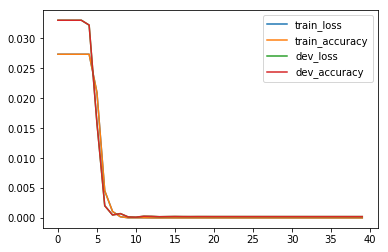

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
affine_in (Dense)            multiple                  6         
_________________________________________________________________
gru (GRU)                    multiple                  3264      
_________________________________________________________________
affine_out (Dense)           multiple                  33        
Total params: 3,303
Trainable params: 3,303
Non-trainable params: 0
_________________________________________________________________


In [5]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = RNN(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=40, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.show()

trainer.save_model(model, optimizer, dataset_val, hparams, 'rnn_affine_' + get_fields.replace(' ', '_'), stats=stats)
model.summary()

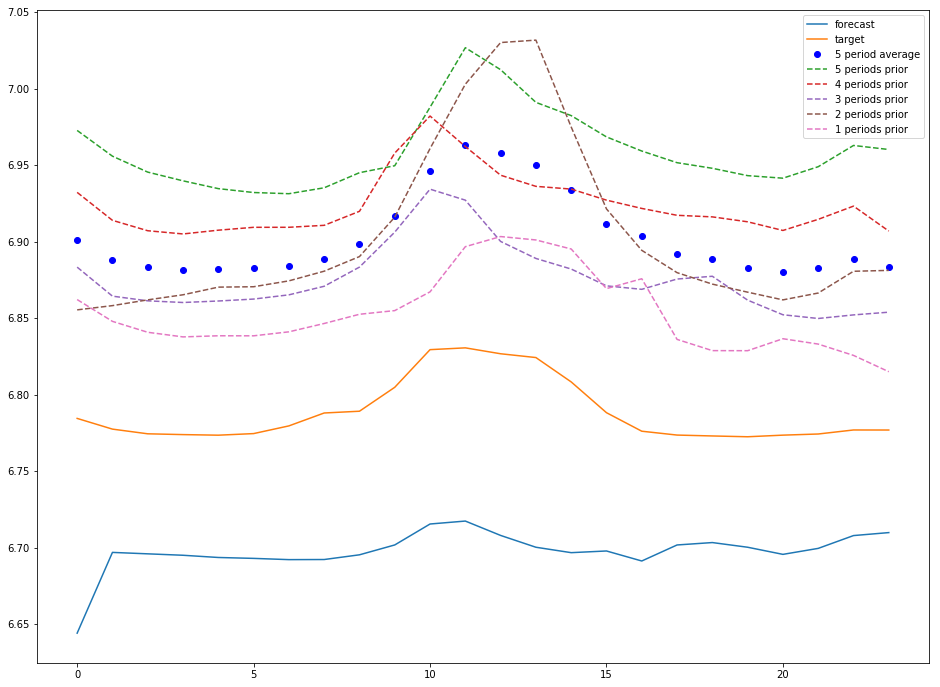

In [6]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
hidden = model.reset_states()
forecast = model(inp, hidden)
forecast *= tf.keras.backend.expand_dims(x_max)
target   *= tf.keras.backend.expand_dims(x_max)
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

### Test Hyperparameters

In [ ]:
np.random.seed(231)
models = []

#for nodes in np.floor(2 ** np.arange(3,9)):
#for lr in np.random.uniform(-8, -1, 10):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = Model(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs = 20, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*100, accuracy * 100, run_time))
    
    models.append(model)